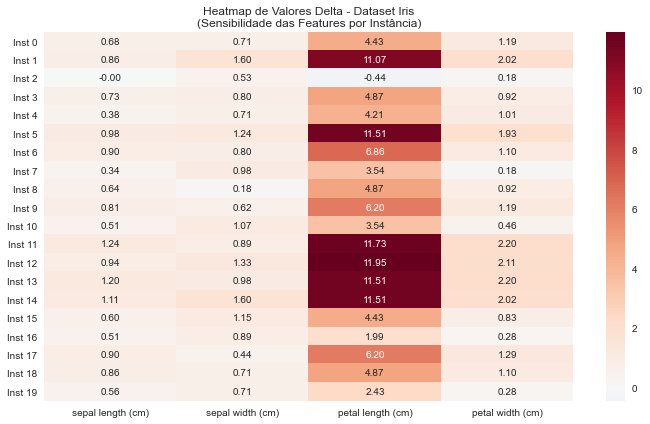


Features selecionadas (percentil 10):
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Features selecionadas (percentil 25):
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Features selecionadas (percentil 50):
['petal length (cm)', 'petal width (cm)']

Features selecionadas (percentil 75):
['petal length (cm)']

Resultados da Redução de Features:
   percentile  num_features  accuracy  train_time
0          10             4       1.0    0.000325
1          25             4       1.0    0.012757
2          50             2       1.0    0.015921
3          75             1       1.0    0.007838


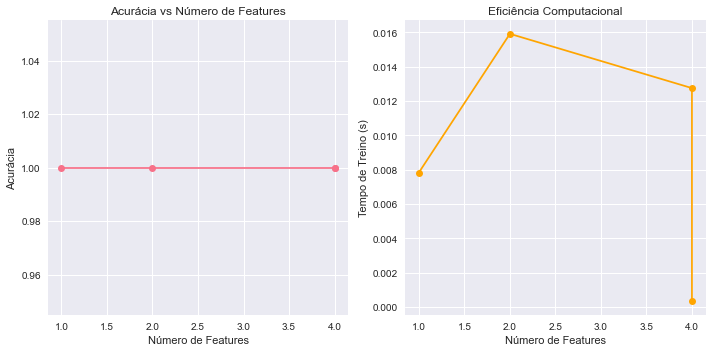


Ranking de Importância das Features:
             Feature  Importância
2  petal length (cm)     6.264305
3   petal width (cm)     1.135853
1   sepal width (cm)     0.923495
0  sepal length (cm)     0.741450

Verificação com conhecimento de domínio:
-> Em botânica, comprimento da sépala é conhecido como o fator mais discriminativo para Iris Setosa
-> Nosso método identificou 'petal length (cm)' como a feature mais importante


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

# Configurações de estilo
plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline

## 1. Funções Base (Adaptadas do seu código)

def pi_explanation(model, X_train, X_test_instance, feature_names):
    """
    Calcula os valores delta para uma instância de teste
    """
    Vs = X_test_instance.to_dict()
    w = model.coef_[0]
    
    deltas = []
    for i, feature in enumerate(feature_names):
        if w[i] < 0:
            delta = (Vs[feature] - X_train[feature].max()) * w[i]
        else:
            delta = (Vs[feature] - X_train[feature].min()) * w[i]
        deltas.append(delta)
    
    return np.array(deltas)

def train_and_explain(X, y, dataset_name, class_0_name):
    """
    Pipeline completo: treina modelo e gera explicações
    """
    # Split dos dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Treina modelo
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Calcula deltas para todas instâncias de teste
    deltas = []
    for i in range(len(X_test)):
        delta = pi_explanation(model, X_train, X_test.iloc[i], X.columns.tolist())
        deltas.append(delta)
    
    return model, X_train, X_test, y_train, y_test, np.array(deltas)

## 2. Análise com Dataset Iris (Exemplo)

# Carrega dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = (iris.target == 0).astype(int)  # Binário: setosa vs não-setosa

# Executa pipeline
model, X_train, X_test, y_train, y_test, deltas = train_and_explain(X, y, "Iris", "Setosa")

## 3. Visualização 1: Heatmap de Deltas

plt.figure(figsize=(10, 6))
sns.heatmap(deltas[:20],  # Mostra apenas 20 primeiras instâncias
            annot=True, 
            fmt=".2f",
            cmap="RdBu_r", 
            center=0,
            xticklabels=X.columns,
            yticklabels=[f"Inst {i}" for i in range(20)])
plt.title("Heatmap de Valores Delta - Dataset Iris\n(Sensibilidade das Features por Instância)")
plt.tight_layout()
plt.show()

## 4. Análise 2: Redução de Features

def evaluate_feature_reduction(X_train, X_test, y_train, y_test, model, deltas, threshold_percentile=25):
    """
    Avalia performance usando apenas features mais importantes
    """
    # Limiar para considerar feature importante
    threshold = np.percentile(np.abs(deltas), threshold_percentile)
    
    # Médias absolutas dos deltas por feature
    mean_abs_deltas = np.mean(np.abs(deltas), axis=0)
    
    # Features selecionadas
    selected_features = np.where(mean_abs_deltas > threshold)[0]
    print(f"\nFeatures selecionadas (percentil {threshold_percentile}):")
    print([X.columns[i] for i in selected_features])
    
    # Reduz datasets
    X_train_reduced = X_train.iloc[:, selected_features]
    X_test_reduced = X_test.iloc[:, selected_features]
    
    # Treina modelo reduzido
    start_time = time.time()
    model_reduced = LogisticRegression(max_iter=1000)
    model_reduced.fit(X_train_reduced, y_train)
    train_time = time.time() - start_time
    
    # Avalia
    y_pred = model_reduced.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    
    return {
        'percentile': threshold_percentile,
        'num_features': len(selected_features),
        'accuracy': acc,
        'train_time': train_time,
        'selected_features': selected_features
    }

# Testa com diferentes percentis
results = []
for percentile in [10, 25, 50, 75]:
    res = evaluate_feature_reduction(X_train, X_test, y_train, y_test, model, deltas, percentile)
    results.append(res)

# DataFrame com resultados
df_results = pd.DataFrame(results)
print("\nResultados da Redução de Features:")
print(df_results[['percentile', 'num_features', 'accuracy', 'train_time']])

## 5. Visualização 2: Trade-off Features vs Performance

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_results['num_features'], df_results['accuracy'], 'o-')
plt.xlabel('Número de Features')
plt.ylabel('Acurácia')
plt.title('Acurácia vs Número de Features')

plt.subplot(1, 2, 2)
plt.plot(df_results['num_features'], df_results['train_time'], 'o-', color='orange')
plt.xlabel('Número de Features')
plt.ylabel('Tempo de Treino (s)')
plt.title('Eficiência Computacional')
plt.tight_layout()
plt.show()

## 6. Análise 3: Validação com Conhecimento de Domínio (Iris)

# Features mais importantes no geral
mean_delta_importance = np.mean(np.abs(deltas), axis=0)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importância': mean_delta_importance
}).sort_values('Importância', ascending=False)

print("\nRanking de Importância das Features:")
print(feature_importance)

